In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

# Load the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)




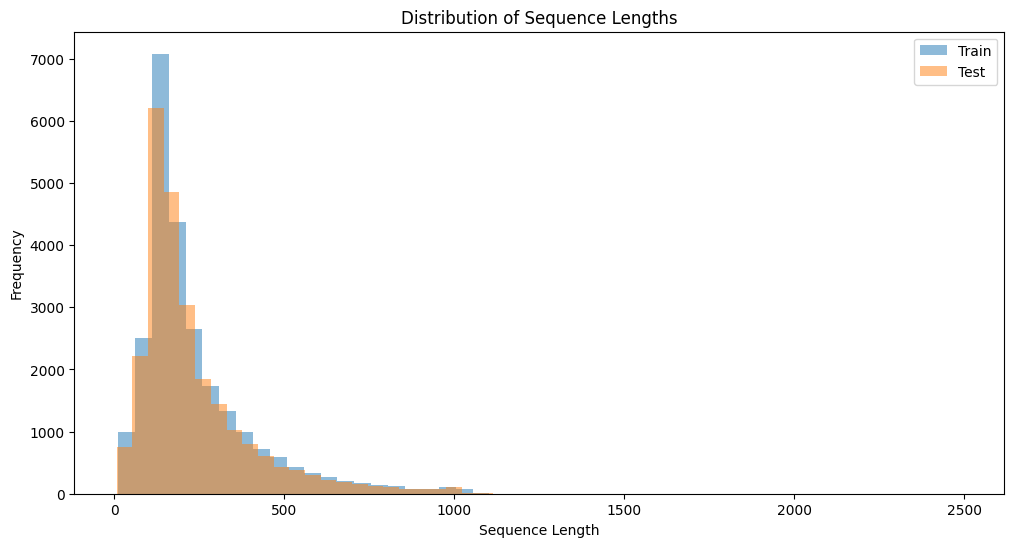

Train sequences - Mean length: 238.71364, Max length: 2494
Test sequences - Mean length: 230.8042, Max length: 2315


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Get the lengths of sequences
train_lengths = [len(seq) for seq in train_data]
test_lengths = [len(seq) for seq in test_data]

# Plot distribution of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, alpha=0.5, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.5, label='Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Sequence Lengths')
plt.show()

# Print some statistics
print(f"Train sequences - Mean length: {np.mean(train_lengths)}, Max length: {np.max(train_lengths)}")
print(f"Test sequences - Mean length: {np.mean(test_lengths)}, Max length: {np.max(test_lengths)}")


In [3]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

print(f"Class weights: {class_weights_dict}")


Class weights: {0: 1.0, 1: 1.0}


In [4]:

MAX_SEQUENCE_LENGTH = 1200  # Adjust based on distribution analysis

# Pad sequences
train_data_padded = pad_sequences(train_data, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_data_padded = pad_sequences(test_data, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Padded training data shape: {train_data_padded.shape}")
print(f"Padded testing data shape: {test_data_padded.shape}")


Padded training data shape: (25000, 1200)
Padded testing data shape: (25000, 1200)


IMDB DB of Tensor flow in already tokenized

Model

In [5]:
MAX_SEQUENCE_LENGTH = 1200
EMBEDDING_DIM = 128
VOCAB_SIZE = 10000

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GRU, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D, Attention, Input

# Define the model using the functional API to handle the Attention layer properly
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding layer
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_layer)

# Unidirectional GRU layer
gru_layer = GRU(units=128, return_sequences=True)(embedding_layer)
dropout_1 = Dropout(0.3)(gru_layer)
batch_norm_1 = BatchNormalization()(dropout_1)

# Attention mechanism - Using the GRU output as both query and value
attention_output = Attention()([batch_norm_1, batch_norm_1])

# Global Average Pooling
gap_layer = GlobalAveragePooling1D()(attention_output)

# Fully connected layer
dense_1 = Dense(128, activation='relu')(gap_layer)
dropout_2 = Dropout(0.5)(dense_1)

# Another fully connected layer
dense_2 = Dense(64, activation='relu')(dropout_2)
dropout_3 = Dropout(0.5)(dense_2)

# Output layer
output_layer = Dense(1, activation='sigmoid')(dropout_3)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an appropriate loss function and optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Training the Model

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data_padded, train_labels, test_size=0.2, random_state=42)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 408s 651ms/step - accuracy: 0.6696 - loss: 0.5753 - val_accuracy: 0.8700 - val_loss: 0.3057
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 406s 649ms/step - accuracy: 0.9043 - loss: 0.2540 - val_accuracy: 0.8604 - val_loss: 0.3568
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 408s 653ms/step - accuracy: 0.9399 - loss: 0.1666 - val_accuracy: 0.7980 - val_loss: 0.5463
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 410s 656ms/step - accuracy: 0.9568 - loss: 0.1286 - val_accuracy: 0.8302 - val_loss: 0.4784


Evaluating the Model

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.8695 - loss: 0.3067
Validation Loss: 0.30573368072509766
Validation Accuracy: 0.8700000047683716


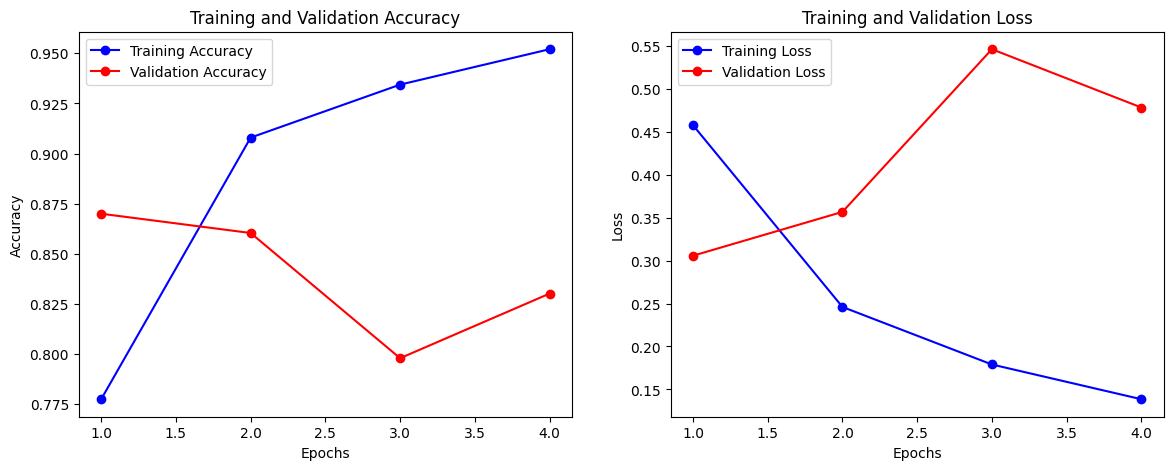

In [9]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Plot the training and validation loss and accuracy over epochs
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


Hyperparameter Tuning

In [11]:
import numpy as np
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, BatchNormalization, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define constants
VOCAB_SIZE = 20000 
EMBEDDING_DIM = 128
MAX_SEQUENCE_LENGTH = 1200

def build_model(units, dropout_rate, learning_rate):
    model = Sequential([
        Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        GRU(units=units, return_sequences=True),
        Dropout(dropout_rate),
        BatchNormalization(),
        GlobalAveragePooling1D(),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def objective(trial):
    # Hyperparameters to tune
    units = trial.suggest_int('units',32,64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Build and compile the model
    model = build_model(units, dropout_rate, learning_rate)
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Example training and validation data (replace with actual data)
    X_train = np.random.randint(0, VOCAB_SIZE, size=(10000, MAX_SEQUENCE_LENGTH))
    y_train = np.random.randint(0, 2, size=(10000,))
    X_val = np.random.randint(0, VOCAB_SIZE, size=(2000, MAX_SEQUENCE_LENGTH))
    y_val = np.random.randint(0, 2, size=(2000,))

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Return the validation accuracy
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best parameters and best score
print(f'Best Hyperparameters: {study.best_params}')
print(f'Best Validation Accuracy: {study.best_value}')

# Build and evaluate the best model
best_params = study.best_params
best_model = build_model(
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

# Example training and validation data (replace with actual data)
X_train = np.random.randint(0, VOCAB_SIZE, size=(10000, MAX_SEQUENCE_LENGTH))
y_train = np.random.randint(0, 2, size=(10000,))
X_val = np.random.randint(0, VOCAB_SIZE, size=(2000, MAX_SEQUENCE_LENGTH))
y_val = np.random.randint(0, 2, size=(2000,))

best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Model Validation Loss: {val_loss}')
print(f'Best Model Validation Accuracy: {val_accuracy}')


[I 2024-08-09 05:48:17,909] A new study created in memory with name: no-name-1b4a03fa-6bdd-4ab7-bf7c-ace2aa3f44ec
c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-08-09 05:53:22,597] Trial 0 finished with value: 0.4950000047683716 and parameters: {'units': 38, 'dropout_rate': 0.4473492871942039, 'learning_rate': 0.000529994559541852}. Best is trial 0 with value: 0.4950000047683716.
[I 2024-08-09 05:58:46,250] Trial 1 finished with value: 0.5034999847412109 and parameters: {'units': 52, 'dropout_rate': 0.4728948986954423, 'learning_rate': 5.4408949277902044e-05}. Best is trial 1 with value: 0.5034999847412109.
[I 2024-08-09 06:04:01,120] Trial 2 finished with value: 0.5325000286102295 and parameters: {'units': 46, 'dropout_rate': 0.30701674500091086, 'learning_rate': 0.00015654261282853658}. Best is trial 2 with value: 0.532500028610

Best Hyperparameters: {'units': 46, 'dropout_rate': 0.30701674500091086, 'learning_rate': 0.00015654261282853658}
Best Validation Accuracy: 0.5325000286102295
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 205ms/step - accuracy: 0.4975 - loss: 0.6934 - val_accuracy: 0.5015 - val_loss: 0.6932
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 201ms/step - accuracy: 0.6859 - loss: 0.6710 - val_accuracy: 0.5040 - val_loss: 1.0036
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 200ms/step - accuracy: 0.8356 - loss: 0.4087 - val_accuracy: 0.4930 - val_loss: 0.8854
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 200ms/step - accuracy: 0.9410 - loss: 0.1839 - val_accuracy: 0.4985 - val_loss: 1.6252
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 200ms/step - accuracy: 0.9740 - loss: 0.0818 - val_accuracy: 0.5055 - val_loss: 1.7697
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 199ms/step - accuracy: 0.9883 - loss: 0.0465 - val_accuracy: 0.5125 - val_loss: 2.0910
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 198ms/step 

Comparative Analysis

In [ ]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
import numpy as np

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define constants
VOCAB_SIZE = 20000  # Example value, replace with actual vocabulary size
EMBEDDING_DIM = 128  # Example value, replace with actual embedding dimension
MAX_SEQUENCE_LENGTH = 100  # Example value, replace with actual max sequence length

def build_ffnn(input_length, vocab_size, embedding_dim):
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        
        # Flatten the output of the embedding layer
        Flatten(),
        
        # Fully connected layer
        Dense(128, activation='relu'),
        
        # Dropout for regularization
        Dropout(0.5),
          
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Example training and validation data (replace with actual data)
X_train = np.random.randint(0, VOCAB_SIZE, size=(10000, MAX_SEQUENCE_LENGTH))
y_train = np.random.randint(0, 2, size=(10000,))
X_val = np.random.randint(0, VOCAB_SIZE, size=(2000, MAX_SEQUENCE_LENGTH))
y_val = np.random.randint(0, 2, size=(2000,))

# Build and train the FFNN model
ffnn_model = build_ffnn(input_length=MAX_SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

ffnn_history = ffnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = ffnn_model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')



Epoch 1/20


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5079 - loss: 0.6951 - val_accuracy: 0.5035 - val_loss: 0.6967
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9999 - loss: 0.1128 - val_accuracy: 0.5005 - val_loss: 0.9714
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 1.0000 - loss: 7.0876e-04 - val_accuracy: 0.4985 - val_loss: 1.0194
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5014 - loss: 0.6980
Validation Loss: 0.696743905544281
Validation Accuracy: 0.5034999847412109


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5014 - loss: 0.6980
FFNN Validation Loss: 0.696743905544281
FFNN Validation Accuracy: 0.5034999847412109


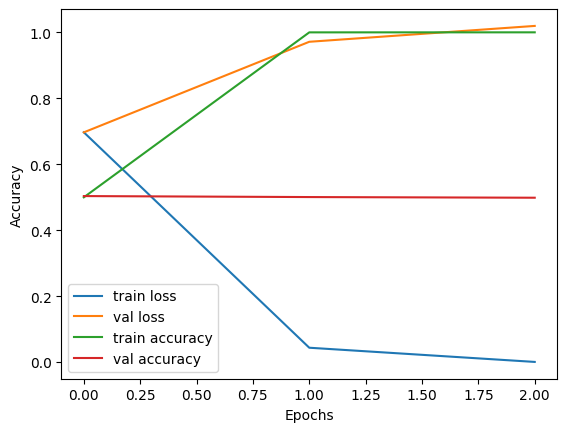

In [ ]:
import matplotlib.pyplot as plt
# Evaluate the FNN model
ffnn_val_loss, ffnn_val_accuracy = ffnn_model.evaluate(X_val, y_val)
print(f'FFNN Validation Loss: {ffnn_val_loss}')
print(f'FFNN Validation Accuracy: {ffnn_val_accuracy}')


# Plot training and validation loss
plt.plot(ffnn_history.history['loss'], label='train loss')
plt.plot(ffnn_history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot training and validation accuracy
plt.plot(ffnn_history.history['accuracy'], label='train accuracy')
plt.plot(ffnn_history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
